<a href="https://colab.research.google.com/github/So-yeon9/Tobigs20/blob/main/Week6/NN_Adv_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NN Adv Assignment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Data

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/Test.csv')

In [4]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train['label'].nunique()

10

In [6]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values

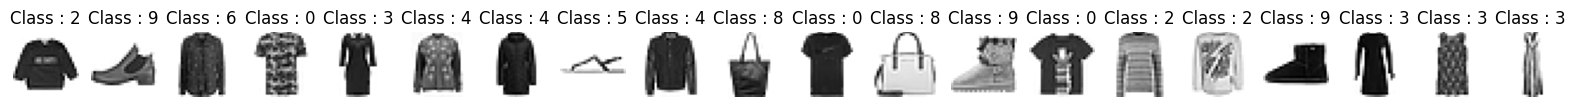

In [8]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [9]:
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

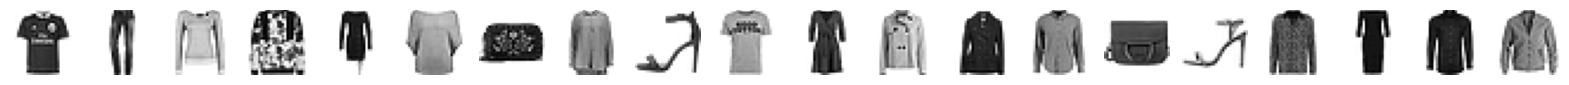

In [10]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [12]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cuda


In [54]:
#Batch Size는 조정 가능합니다.
BATCH_SIZE = 128
#Epoch는 고정해주세요.
EPOCHS = 15

In [14]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [20]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [23]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()

  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

## 직접 Network를 설계하고, 성능을 시험해보자.

### 참고: https://wikidocs.net/63618

In [104]:
class MyNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        nn.init.kaiming_normal_(self.fc1.weight,  nonlinearity='relu')
        self.stack1 = nn.Sequential(
            self.fc1,
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        self.fc2 = nn.Linear(1024, 512)
        nn.init.kaiming_normal_(self.fc2.weight,  nonlinearity='relu')
        self.stack2 = nn.Sequential(
            self.fc2,
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        self.fc3 = nn.Linear(512, 256)
        nn.init.kaiming_normal_(self.fc3.weight,  nonlinearity='relu')
        self.stack3 = nn.Sequential(
            self.fc3,
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        self.fc4 = nn.Linear(256, 128)
        nn.init.kaiming_normal_(self.fc4.weight,  nonlinearity='relu')
        self.stack4 = nn.Sequential(
            self.fc4,
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        self.fc5 = nn.Linear(128, 64)
        nn.init.kaiming_normal_(self.fc5.weight,  nonlinearity='relu')
        self.stack5 = nn.Sequential(
            self.fc5,
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        self.fc6 = nn.Linear(64, 10)
        nn.init.kaiming_normal_(self.fc6.weight,  nonlinearity='relu')

    def forward(self, x):
        x = self.stack1(x)
        x = self.stack2(x)
        x = self.stack3(x)
        x = self.stack4(x)
        x = self.fc5(x)
        return x

model = MyNet().to(DEVICE)
#적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)   # optimizer로 Adam 사용
#적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.5263, 	Train Accuracy: 81.96 %, 	Val Loss: 0.3984, 	Val Accuracy: 85.19 % 

[EPOCH: 2], 	Train Loss: 0.3822, 	Train Accuracy: 86.13 %, 	Val Loss: 0.3669, 	Val Accuracy: 86.54 % 

[EPOCH: 3], 	Train Loss: 0.3408, 	Train Accuracy: 87.58 %, 	Val Loss: 0.3204, 	Val Accuracy: 88.08 % 

[EPOCH: 4], 	Train Loss: 0.3143, 	Train Accuracy: 88.42 %, 	Val Loss: 0.3202, 	Val Accuracy: 88.01 % 

[EPOCH: 5], 	Train Loss: 0.2939, 	Train Accuracy: 89.13 %, 	Val Loss: 0.3471, 	Val Accuracy: 87.22 % 

[EPOCH: 6], 	Train Loss: 0.2753, 	Train Accuracy: 89.85 %, 	Val Loss: 0.3220, 	Val Accuracy: 88.27 % 

[EPOCH: 7], 	Train Loss: 0.2618, 	Train Accuracy: 90.31 %, 	Val Loss: 0.3543, 	Val Accuracy: 86.94 % 

[EPOCH: 8], 	Train Loss: 0.2437, 	Train Accuracy: 90.88 %, 	Val Loss: 0.3038, 	Val Accuracy: 88.79 % 

[EPOCH: 9], 	Train Loss: 0.2309, 	Train Accuracy: 91.28 %, 	Val Loss: 0.3216, 	Val Accuracy: 88.30 % 

[EPOCH: 10], 	Train Loss: 0.2237, 	Train Accuracy: 91.62 %, 	Val Loss: 0.

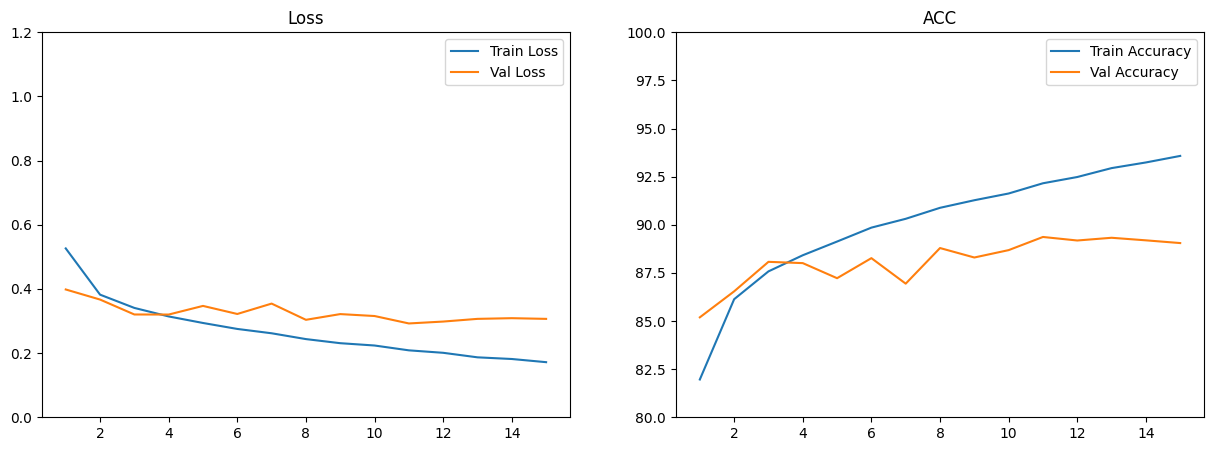

In [105]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}

  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1.2)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## Test Accuracy 체크

In [118]:
y_test = torch.LongTensor(y_test)
test_dataset = DataSet(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

test_loss, test_accuracy = evaluate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")

Test Loss: 1.7964, 	Test Accuracy: 80.81 % 



80.81% 로 train accuracy와 test accuracy보다는 좀 더 낮은 정확도를 얻는다.

## 결론을 작성해주세요:

**Optimization**
- Adam 사용하였음.
- 처음 시도할 때는 learning rate scheduling (exponential, step, cosine)도 사용했으나 validation accuracy가 85% 근방을 맴돌아서 제외하였음.

**Regularization** - dropout(10%)  
1.   dropout만 사용  
89%의 val accuracy 에 도달하며 이해할 수 있는 폭 내에서 에포크별 성능의 변동이 있음
2.   L2 regularization 사용  
dropout과 함께 사용하든, 단독으로 사용하든 val 성능이 에포크마다 너무 다르게
변동폭이 크게 나오며 val 성능도 dropout만 사용했을 때에 비해 약간 낮음
- 결론: 따라서 regularization 방안으로 1안을 채택하였음.


**Initialization**  
- 활성화함수로 ReLU 를 사용하였으므로 He initialization 사용하였음.

**Normalization**
- Batch normalization

추가)  
learning rate의 값에 따라 성능이 급격히 변하는 것을 보며 다른 hyper parameter보다도 learning rate를 설정하는 데 가장 많은 시간을 들이는 것이 좋겠다고 생각하였음.